<h1>Numba tuning: simple convolution based matching</h1><br>
...explanation should go here ...
As a next step, horizontal and vertical edge detector filters will be used to extract features of the images.
Then, this features will be added back to the original image in the hope of helping along in detecting edges strengthening the matching algorithm.

In [1]:
colab = False
try:
  from google.colab import drive
  drive.mount("/content/gdrive")
  colab = True
except Exception:
  pass

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
cd '/content/gdrive/My Drive/python_projects/FYP'

/content/gdrive/My Drive/python_projects/FYP


In [0]:
import numpy as np
from components.classes.NumbaSimpleMatcher import Wrapper as m
from components.non_oo_entities import utils as u
import imp
import cv2
import os
import matplotlib.pyplot as plt
import gc
from components.classes.CSVExperimentLogger import CSVExperimentLogger as l
from components.classes.Metrix import Metrix as me
import time

Please select resolution: 0 for small, 1 for medium and 2 for the original image size:


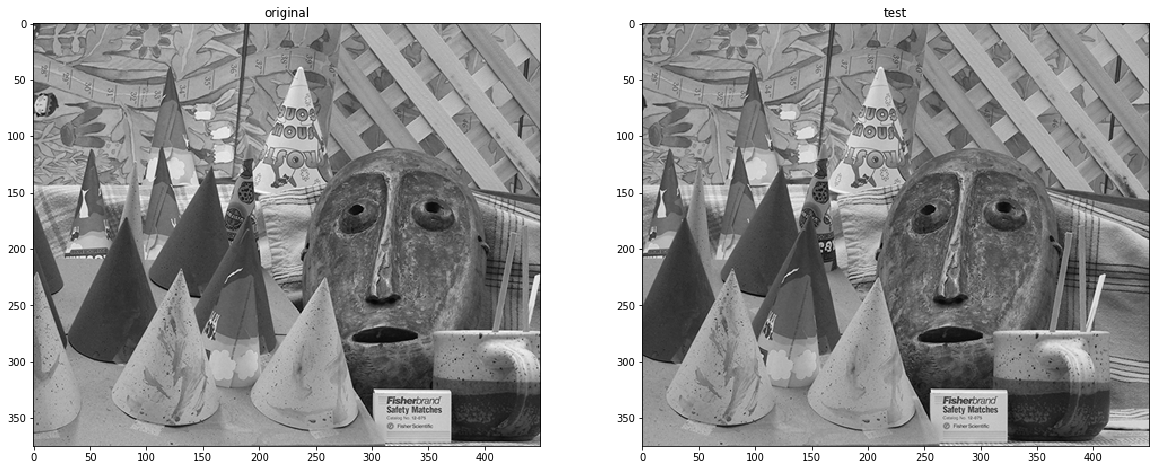

In [0]:
resolutions = list(["", "H", "F"])
print("Please select resolution: 0 for small, 1 for medium and 2 for the original image size:")
selectedResolutionIndex = 0#int(input())
im2 = cv2.imread("./datasets/middlebury_2003/cones"+resolutions[selectedResolutionIndex]+"/im2.ppm", cv2.IMREAD_GRAYSCALE).astype(np.float64)
im6 = cv2.imread("./datasets/middlebury_2003/cones"+resolutions[selectedResolutionIndex]+"/im6.ppm", cv2.IMREAD_GRAYSCALE).astype(np.float64)
u.plotTwoImages(im2, im6, title = "test")    
occlusion_path = "metrix_test/gt/cones_nonocc.png"
occlusion_map = cv2.imread(occlusion_path, cv2.IMREAD_GRAYSCALE).astype(np.float64)

gt_path = "./metrix_test/gt/cones_groundtruth.png"
groundtruth = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
groundtruth_occluded = u.add_occlusions(groundtruth, occlusion_map)/4


Number of processors:  2


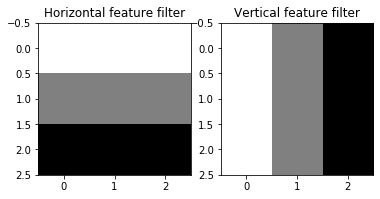

In [0]:
from components.classes import SimpleConvolution as SC

convolver = SC.getOne()

im2_blurred = convolver.convolve(im2)
im6_blurred = convolver.convolve(im6)

u.getHorizontalFeatureFilter(convolver)

horizontal_feature = convolver.filter

im2_h = convolver.convolve(im2)
im6_h = convolver.convolve(im6)

u.getVerticalFeatureFilter(convolver)

vertical_feature = convolver.filter

im2_v = convolver.convolve(im2)
im6_v = convolver.convolve(im6)

im2_features_added = im2+im2_v+im2_h
im6_features_added = im6+im6_v+im6_h


im2s = [im2,im2_blurred,  im2_h, im2_v, im2_features_added]
im6s = [im6, im6_blurred, im6_h, im6_v, im6_features_added]

ax = plt.subplot(121)
ax.set_title("Horizontal feature filter")
plt.imshow(horizontal_feature, "gray")
ax = plt.subplot(122)
ax.set_title("Vertical feature filter")
plt.imshow(vertical_feature, "gray")

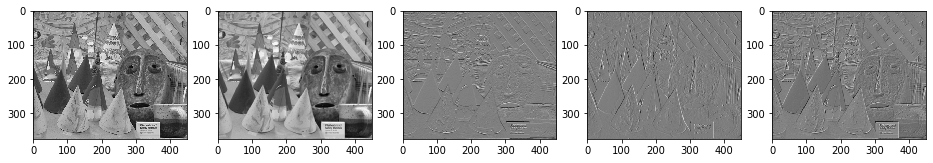

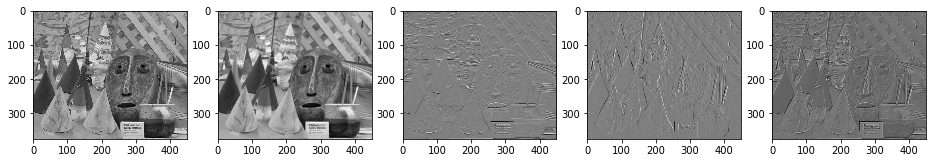

In [0]:
u.plotNImages(im2s)
u.plotNImages(im6s)    

Please specify match, gap and egap values in the cell below:

In [0]:
#loop_params
match_max = 100
gap_min = -100
egap_min=-30

log = l(file_path = "./test_outputs_numba_convolved/numba2_inverse_convolved_scores.csv")

spec_dict = dict({})
spec_dict["output_folder"] = "./test_outputs_numba_convolved/"

spec_dict["is_parallel"] = "True"
spec_dict["img_name"] = "cones"
spec_dict["alg_type"] =  "simle_numba_matcher"
spec_dict["is_img_preprocessed"] = "False"
spec_dict["convolution_filters"] = "-"
spec_dict["filter_strategy"] = "-"
spec_dict["matching_mode"] = non_occ =  "non_occ"
spec_dict["matrix_init_mode"] = 0
match = spec_dict["match"] = 0
gap = spec_dict["gap"] = 0
egap = spec_dict["egap"] = 0
print("Please define the output image's extension")
spec_dict["ext"] = "png" #input()
filter_modes = ["-","blurred",  "horizontal", "vertical", "h_v_ori"]

Please define the output image's extension


In [0]:
log.write_csv_header()
for m_score in range(match_max, 0, -1):
  for gap_score in range(-20, gap_min, -1):
    for egap_score in range(-1, egap_min, -1):
      matcher = m(m_score, gap_score, egap_score)
      filter_counter = 0
      for imA, imB in zip(im2s, im6s):
        spec_dict["convolution_filters"] = filter_modes[filter_counter]
        filter_counter+=1
        spec_dict["matrix_init_mode"] = 2
        match = spec_dict["match"] = m_score
        gap = spec_dict["gap"] = gap_score
        egap = spec_dict["egap"] = egap_score
        
        
        matcher.set_images(imB, imA)  
        matcher.configure_instance()      
        tic=time.time()
        %time x,raw_disp_map = matcher.run_pipeline()
        toc = time.time()
        
        'raw_disp_map = 255-(raw_disp_map/np.max(raw_disp_map)*255)'
        
        disp_occluded = u.add_occlusions(raw_disp_map, occlusion_map)
        
        #u.plotNImages2([im2, groundtruth_occluded, disp_occluded], cols=3)
        
        wanna_print = False
        spec_dict["runtime"] = toc-tic
        spec_dict["bad1"] = me.bad(disp_occluded, groundtruth_occluded, threshold = 1.0, non_occ= non_occ, print=wanna_print, occlusion_map = occlusion_map)
        spec_dict["bad15"] = me.bad(disp_occluded, groundtruth_occluded, threshold = 1.5, non_occ= non_occ, print=wanna_print, occlusion_map = occlusion_map)
        spec_dict["bad2"] = me.bad(disp_occluded, groundtruth_occluded, threshold = 2, non_occ= non_occ, print=wanna_print, occlusion_map = occlusion_map)
        spec_dict["BAD8"] = me.bad(disp_occluded, groundtruth_occluded, threshold = 10.0, non_occ= non_occ, print=wanna_print, occlusion_map = occlusion_map)

        spec_dict["ABS_ERR"] = me.avgerr(disp_occluded, groundtruth_occluded, print=wanna_print, occlusion_map = occlusion_map)

        filename = u.get_output_filename(spec_dict)
        spec_dict["output_file_path"] = os.path.join(spec_dict["output_folder"], filename)
        log.write_matchin_ended(spec_dict)
        cv2.imwrite(spec_dict["output_file_path"], raw_disp_map)
        break
      filter_counter=0

Streaming output truncated to the last 5000 lines.
I am logging.
CPU times: user 12.4 s, sys: 55.9 ms, total: 12.5 s
Wall time: 6.45 s
I am logging.
CPU times: user 12.4 s, sys: 50.9 ms, total: 12.5 s
Wall time: 6.43 s
I am logging.
CPU times: user 12.4 s, sys: 36.9 ms, total: 12.4 s
Wall time: 6.41 s
I am logging.
CPU times: user 12.4 s, sys: 59.9 ms, total: 12.5 s
Wall time: 6.44 s
I am logging.
CPU times: user 12.6 s, sys: 50.9 ms, total: 12.6 s
Wall time: 6.52 s
I am logging.
CPU times: user 12.5 s, sys: 56.9 ms, total: 12.5 s
Wall time: 6.47 s
I am logging.
CPU times: user 12.5 s, sys: 64.9 ms, total: 12.6 s
Wall time: 6.47 s
I am logging.
CPU times: user 12.5 s, sys: 62.9 ms, total: 12.5 s
Wall time: 6.46 s
I am logging.
CPU times: user 12.4 s, sys: 61.9 ms, total: 12.5 s
Wall time: 6.47 s
I am logging.
CPU times: user 12.5 s, sys: 60.9 ms, total: 12.5 s
Wall time: 6.45 s
I am logging.
CPU times: user 12.4 s, sys: 55.9 ms, total: 12.5 s
Wall time: 6.48 s
I am logging.
CPU times: 